https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults

import datetime
import sys
import seaborn as sns
import statsmodels
import statsmodels.stats.diagnostic as diag
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from scipy.stats.mstats import normaltest
from matplotlib.pyplot import acorr
%matplotlib inline
import quandl

import sqlalchemy

import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale = 1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

WINDOW = 22

In [59]:
def connect(user, password, db, host: str, port: int, echo=True):
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)
    eng = sqlalchemy.create_engine(url, client_encoding='utf8', echo=echo)
    meta = sqlalchemy.MetaData(bind=eng)

    return eng, meta


def get_data_frame(pair: str = 'USDT_BTC', exchange: str = 'poloniex') -> pd.DataFrame:
    
    """Метод стягивания данных из базы в датафрейм.
    По умолчанию тянет все значения в базе для валютной пары доллар биткоин.
    Список спаршенных пар смотри в таблице Pair
    Цепляться будет отовсюду где есть инетрнет"""
    engine, meta = connect(user='postgres', password='password', db='btccandles', host='94.230.125.199', port=16432)
    df = pd.read_sql_query(
        "SELECT date, time, open, close, low, high, volume, pair.\"name\""
        "FROM candlestick, pair WHERE candlestick.pair_id = pair.id AND pair.id IN ("
        "SELECT pair.id FROM pair, exchange WHERE ("
        "SELECT pair.id FROM pair WHERE pair.name = '" + pair +
        "') = pair.alias_id AND pair.exchange_id = (SELECT exchange.id FROM exchange WHERE exchange.\"name\" = '" + exchange + "'));",
        con=engine)
    return df


from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [61]:
df = get_data_frame("USDT_BTC")
ts = df[['date','close']][:-1]

2017-07-25 16:51:56,993 INFO sqlalchemy.engine.base.Engine select version()
2017-07-25 16:51:56,993 INFO sqlalchemy.engine.base.Engine {}
2017-07-25 16:51:56,995 INFO sqlalchemy.engine.base.Engine select current_schema()
2017-07-25 16:51:56,995 INFO sqlalchemy.engine.base.Engine {}
2017-07-25 16:51:56,997 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2017-07-25 16:51:56,998 INFO sqlalchemy.engine.base.Engine {}
2017-07-25 16:51:56,999 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2017-07-25 16:51:57,000 INFO sqlalchemy.engine.base.Engine {}
2017-07-25 16:51:57,001 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2017-07-25 16:51:57,001 INFO sqlalchemy.engine.base.Engine {}
2017-07-25 16:51:57,003 INFO sqlalchemy.engine.base.Engine SELECT date, time, open, close, low, high, volume, pair."name"FROM candlestick, pair WHERE candlestick.pair_id = pair.id AND pair.id IN (SELEC

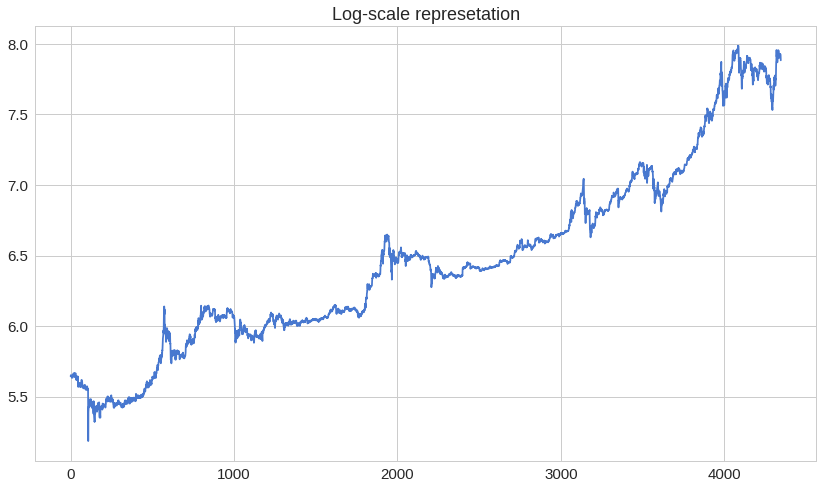

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  


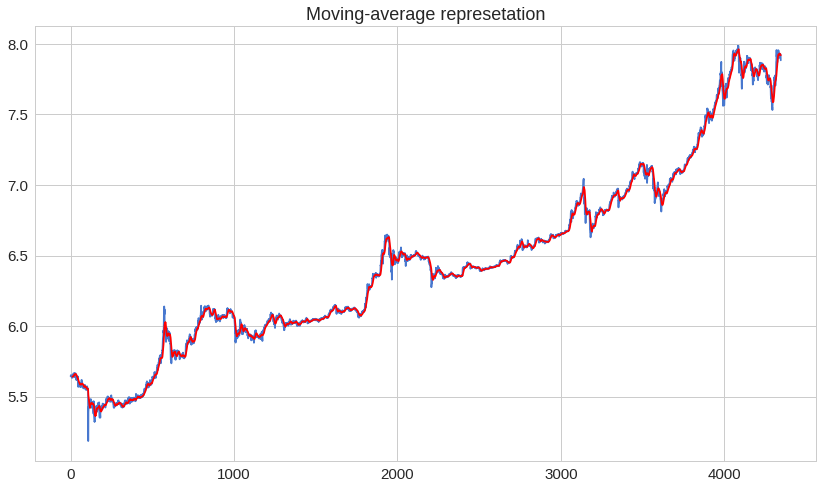

In [67]:
########
ts_log = np.log(ts.close)
plt.plot(ts_log)
plt.title('Log-scale represetation')
plt.show()

######
moving_avg = pd.rolling_mean(ts_log, 12)
plt.plot(ts_log)
plt.title('Moving-average represetation')
plt.plot(moving_avg, color='red')
plt.show()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.


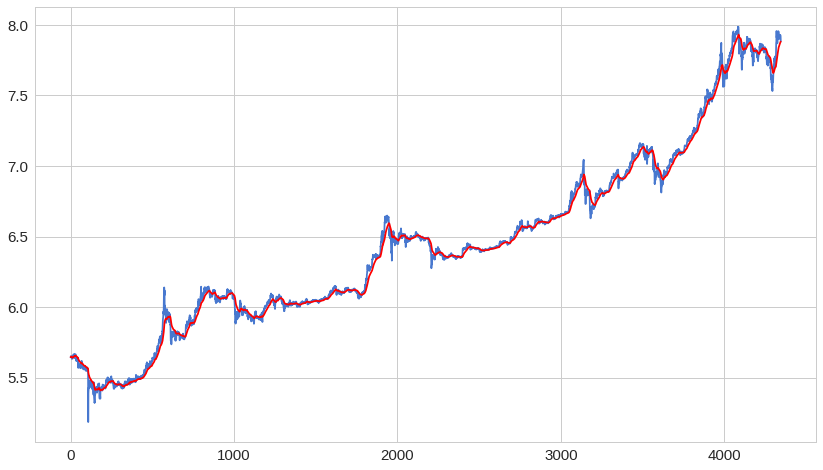

In [68]:
expwighted_avg = pd.ewma(ts_log, halflife = 12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


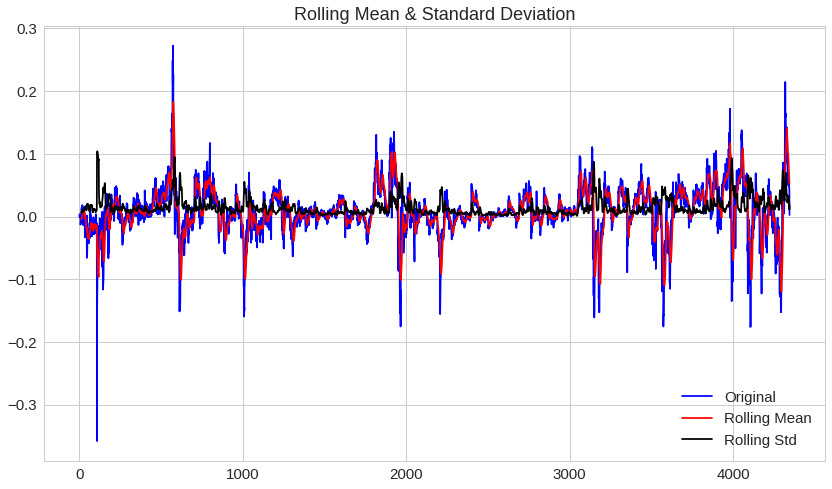

Results of Dickey-Fuller Test:
Test Statistic                -9.146365e+00
p-value                        2.761054e-15
#Lags Used                     2.000000e+01
Number of Observations Used    4.326000e+03
Critical Value (1%)           -3.431863e+00
Critical Value (5%)           -2.862208e+00
Critical Value (10%)          -2.567126e+00
dtype: float64


In [69]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

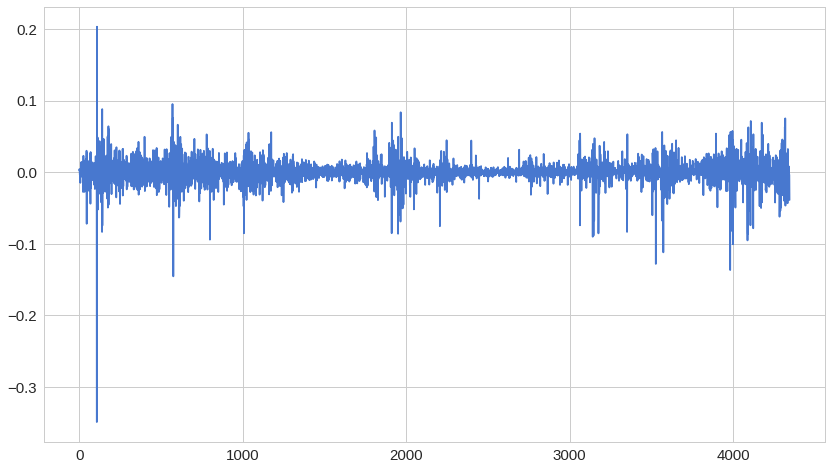

In [70]:
# Differencing

ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


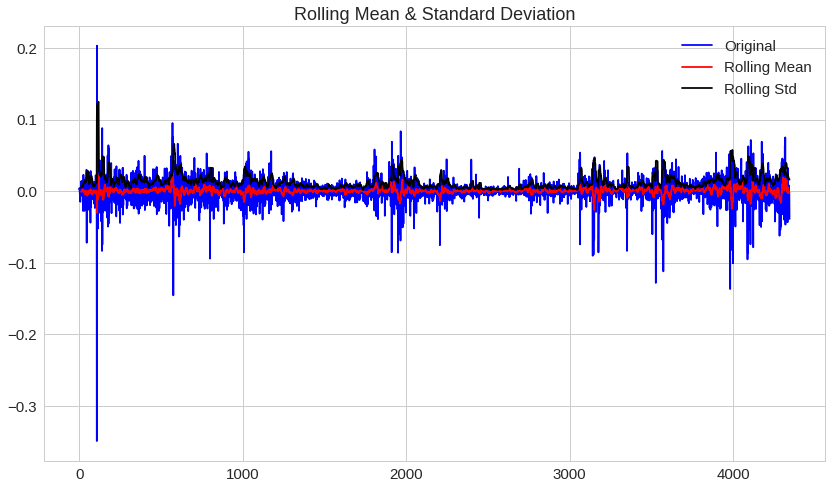

Results of Dickey-Fuller Test:
Test Statistic                -1.543479e+01
p-value                        2.916715e-28
#Lags Used                     1.900000e+01
Number of Observations Used    4.326000e+03
Critical Value (1%)           -3.431863e+00
Critical Value (5%)           -2.862208e+00
Critical Value (10%)          -2.567126e+00
dtype: float64


In [71]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

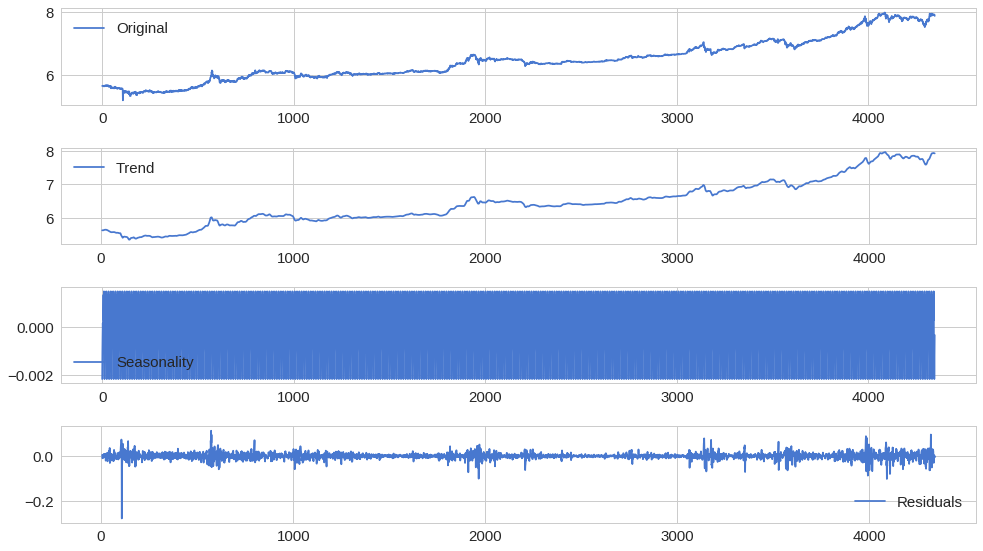

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log.values, freq=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [73]:
ts_log_decompose = residual

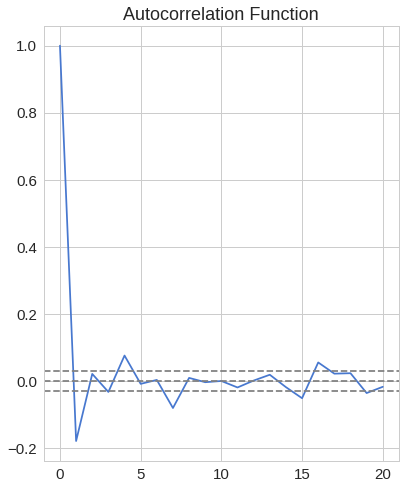

In [74]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

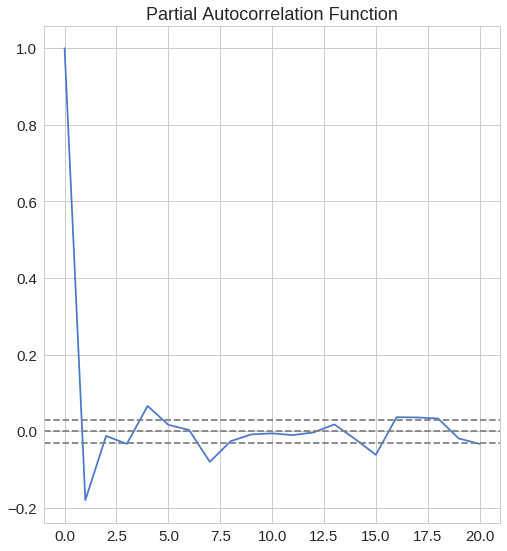

In [75]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

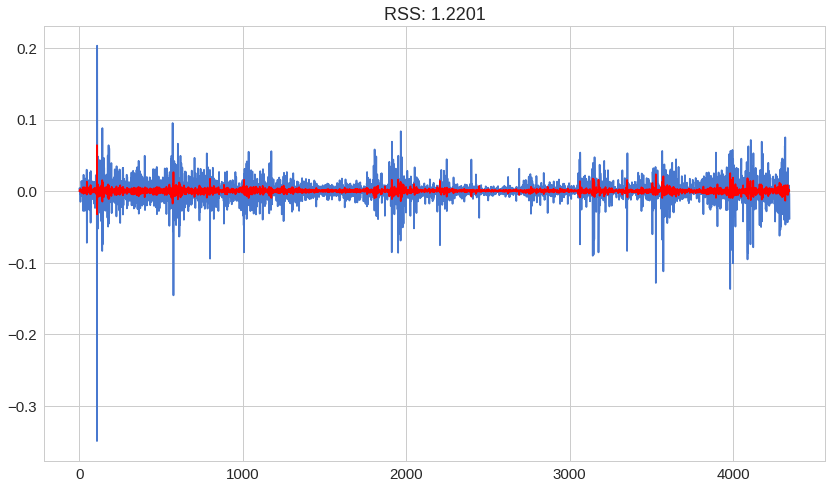

In [82]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log.dropna().as_matrix(), order=(2, 1, 0))  
results_ARIMA = model.fit()  


plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))


In [ ]:
numofsteps = 1
stepahead = results_ARIMA.forecast(numofsteps)[0]
ferrors = results_ARIMA.forecast(numofsteps)[2]
ferrors

print ('%s Steps Ahead Forecast  is:' % numofsteps, np.exp(stepahead))